Import the data. This has to be run first!

In [1]:
import math
import json
import matplotlib.pyplot as plt
from matplotlib import colormaps as cmaps
import numpy as np
from matplotlib.ticker import FuncFormatter
import heapq
import itertools
file_path = '/Users/benedikt/Documents/GitHub/GEO877-FS24-McKenzie/CoGo_Bikerental_Colorado_US/cleaned_data/cleaned_December-cogo-tripdata.csv'
geojson_file_path = '/Users/benedikt/Documents/GitHub/GEO877-FS24-McKenzie/CoGo_Bikerental_Colorado_US/Corporate_Boundary.geojson'
cmap = cmaps['viridis']


Convert the data to the Albers equal-area projection. The function will be used in later steps of the analysis.

In [2]:
def convert_to_albers(lon, lat):
    # Constants for the Albers equal-area projection (EPSG:3310)
    a = 6378137.0  # Semi-major axis
    e = 0.081819191  # Eccentricity
    phi0 = math.radians(37.66666666666666)  # Latitude of the origin
    phi1 = math.radians(38.73333333333333)  # First standard parallel
    phi2 = math.radians(40.03333333333333)  # Second standard parallel
    lambda0 = math.radians(-82.5)  # Central meridian
    fe = 600000.0  # False easting
    fn = 0.0  # False northing

    phi = math.radians(lat)
    lambda_ = math.radians(lon)
    
    n = (math.sin(phi1) + math.sin(phi2)) / 2
    C = math.cos(phi1)**2 + 2 * n * math.sin(phi1)
    rho0 = a * math.sqrt(C - 2 * n * math.sin(phi0)) / n
    rho = a * math.sqrt(C - 2 * n * math.sin(phi)) / n
    theta = n * (lambda_ - lambda0)
    
    x = fe + rho * math.sin(theta)
    y = fn + rho0 - rho * math.cos(theta)
    
    return x, y

Read in the polygon of the boundaries of the city of Columbus. The Polygon will be saved as columbus_bd

In [3]:
# Step 1: Read the GeoJSON file
with open(geojson_file_path, 'r') as f:
    geojson_data = json.load(f)

# Step 2: Extract the single polygon coordinates from the GeoJSON data
# GeoJSON file contains a single Polygon
polygon = []

for feature in geojson_data['features']:
    if feature['geometry']['type'] == 'Polygon':
        polygon = feature['geometry']['coordinates'][0]  # Assuming it's a single polygon
        break
    elif feature['geometry']['type'] == 'MultiPolygon':
        polygon = feature['geometry']['coordinates'][0][0]  # First polygon of the first multipolygon
        break



# Step 4: Convert the coordinates of the polygon to NAD83 / California Albers projection (EPSG:3310)
columbus_bd = [convert_to_albers(lon, lat) for lon, lat in polygon]
columbus_wgs = polygon


Generate the Hexagon grid. The hexagons will be saves as columbus_hexagons.

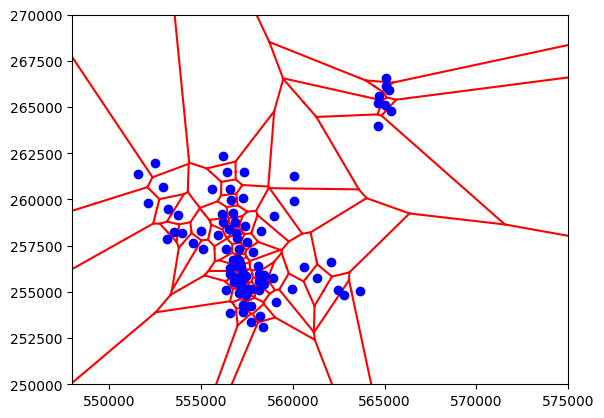

In [4]:
# Define the Point class to represent a point in 2D space
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

# Define the Event class to represent events in the Fortune's algorithm
class Event:
    def __init__(self, x, p, a):
        self.x = x
        self.p = p
        self.a = a
        self.valid = True

# Define the Arc class to represent an arc in the beach line
class Arc:
    def __init__(self, p, a=None, b=None):
        self.p = p
        self.pprev = a
        self.pnext = b
        self.e = None
        self.s0 = None
        self.s1 = None

# Define the Segment class to represent the edges of the Voronoi diagram
class Segment:
    def __init__(self, p):
        self.start = p
        self.end = None
        self.done = False

    # Method to mark the segment as finished by setting its end point
    def finish(self, p):
        if self.done: return
        self.end = p
        self.done = True        

# Define the PriorityQueue class for managing the priority queue of events and points
class PriorityQueue:
    def __init__(self):
        self.pq = []
        self.entry_finder = {}
        self.counter = itertools.count()

    # Method to add an item to the priority queue
    def push(self, item):
        if item in self.entry_finder: return
        count = next(self.counter)
        entry = [item.x, count, item]
        self.entry_finder[item] = entry
        heapq.heappush(self.pq, entry)

    # Method to remove an item from the priority queue
    def remove_entry(self, item):
        entry = self.entry_finder.pop(item)
        entry[-1] = 'Removed'

    # Method to pop the item with the highest priority (lowest value) from the queue
    def pop(self):
        while self.pq:
            priority, count, item = heapq.heappop(self.pq)
            if item != 'Removed':
                del self.entry_finder[item]
                return item
        raise KeyError('pop from an empty priority queue')

    # Method to get the item with the highest priority without removing it from the queue
    def top(self):
        while self.pq:
            priority, count, item = heapq.heappop(self.pq)
            if item != 'Removed':
                del self.entry_finder[item]
                self.push(item)
                return item
        raise KeyError('top from an empty priority queue')

    # Method to check if the priority queue is empty
    def empty(self):
        return not self.pq

# Define the Voronoi class to implement Fortune's algorithm for generating Voronoi diagrams
class Voronoi:
    def __init__(self, points, bbox):
        self.output = []    # List to store the output segments
        self.arc = None     # Pointer to the current arc in the beach line

        self.points = PriorityQueue()    # Priority queue for points
        self.event = PriorityQueue()     # Priority queue for circle events

        self.x0, self.x1, self.y0, self.y1 = bbox  # Bounding box for the diagram

        # Initialize the points in the priority queue
        for pts in points:
            point = Point(pts[0], pts[1])
            self.points.push(point)

    # Method to process the events and points to generate the Voronoi diagram
    def process(self):
        # Process all points and events
        while not self.points.empty():
            if not self.event.empty() and (self.event.top().x <= self.points.top().x):
                self.process_event()
            else:
                self.process_point()

        # Process remaining events
        while not self.event.empty():
            self.process_event()

        # Finish the edges of the Voronoi diagram
        self.finish_edges()

    # Method to process a site event (point)
    def process_point(self):
        p = self.points.pop()
        self.arc_insert(p)

    # Method to process a circle event
    def process_event(self):
        e = self.event.pop()
        if e.valid:
            s = Segment(e.p)
            self.output.append(s)
            a = e.a
            if a.pprev is not None:
                a.pprev.pnext = a.pnext
                a.pprev.s1 = s
            if a.pnext is not None:
                a.pnext.pprev = a.pprev
                a.pnext.s0 = s

            if a.s0 is not None: a.s0.finish(e.p)
            if a.s1 is not None: a.s1.finish(e.p)

            if a.pprev is not None: self.check_circle_event(a.pprev, e.x)
            if a.pnext is not None: self.check_circle_event(a.pnext, e.x)

    # Method to insert an arc into the beach line
    def arc_insert(self, p):
        if self.arc is None:
            self.arc = Arc(p)
        else:
            i = self.arc
            while i is not None:
                flag, z = self.intersect(p, i)
                if flag:
                    flag, zz = self.intersect(p, i.pnext)
                    if (i.pnext is not None) and (not flag):
                        i.pnext.pprev = Arc(i.p, i, i.pnext)
                        i.pnext = i.pnext.pprev
                    else:
                        i.pnext = Arc(i.p, i)
                    i.pnext.s1 = i.s1

                    i.pnext.pprev = Arc(p, i, i.pnext)
                    i.pnext = i.pnext.pprev

                    i = i.pnext

                    seg = Segment(z)
                    self.output.append(seg)
                    i.pprev.s1 = i.s0 = seg

                    seg = Segment(z)
                    self.output.append(seg)
                    i.pnext.s0 = i.s1 = seg

                    self.check_circle_event(i, p.x)
                    self.check_circle_event(i.pprev, p.x)
                    self.check_circle_event(i.pnext, p.x)

                    return
                i = i.pnext

            i = self.arc
            while i.pnext is not None:
                i = i.pnext
            i.pnext = Arc(p, i)

            x = self.x0
            y = (i.pnext.p.y + i.p.y) / 2.0
            start = Point(x, y)

            seg = Segment(start)
            i.s1 = i.pnext.s0 = seg
            self.output.append(seg)

    # Method to check and add a circle event for an arc
    def check_circle_event(self, i, x0):
        if (i.e is not None) and (i.e.x != self.x0):
            i.e.valid = False
        i.e = None

        if (i.pprev is None) or (i.pnext is None): return

        flag, x, o = self.circle(i.pprev.p, i.p, i.pnext.p)
        if flag and (x > self.x0):
            i.e = Event(x, o, i)
            self.event.push(i.e)

    # Method to compute the circumcircle of three points
    def circle(self, a, b, c):
        if ((b.x - a.x)*(c.y - a.y) - (c.x - a.x)*(b.y - a.y)) > 0: return False, None, None

        A = b.x - a.x
        B = b.y - a.y
        C = c.x - a.x
        D = c.y - a.y
        E = A*(a.x + b.x) + B*(a.y + b.y)
        F = C*(a.x + c.x) + D*(a.y + c.y)
        G = 2*(A*(c.y - b.y) - B*(c.x - b.x))

        if (G == 0): return False, None, None

        ox = 1.0 * (D*E - B*F) / G
        oy = 1.0 * (A*F - C*E) / G

        x = ox + math.sqrt((a.x-ox)**2 + (a.y-oy)**2)
        o = Point(ox, oy)
           
        return True, x, o
        
    # Method to check if a new point intersects an arc
    def intersect(self, p, i):
        if (i is None): return False, None
        if (i.p.x == p.x): return False, None

        a = 0.0
        b = 0.0

        if i.pprev is not None:
            a = (self.intersection(i.pprev.p, i.p, 1.0*p.x)).y
        if i.pnext is not None:
            b = (self.intersection(i.p, i.pnext.p, 1.0*p.x)).y

        if (((i.pprev is None) or (a <= p.y)) and ((i.pnext is None) or (p.y <= b))):
            py = p.y
            px = 1.0 * ((i.p.x)**2 + (i.p.y-py)**2 - p.x**2) / (2*i.p.x - 2*p.x)
            res = Point(px, py)
            return True, res
        return False, None

    # Method to find the intersection point of two parabolas
    def intersection(self, p0, p1, l):
        p = p0
        if (p0.x == p1.x):
            py = (p0.y + p1.y) / 2.0
        elif (p1.x == l):
            py = p1.y
        elif (p0.x == l):
            py = p0.y
            p = p1
        else:
            z0 = 2.0 * (p0.x - l)
            z1 = 2.0 * (p1.x - l)

            a = 1.0/z0 - 1.0/z1
            b = -2.0 * (p0.y/z0 - p1.y/z1)
            c = 1.0 * (p0.y**2 + p0.x**2 - l**2) / z0 - 1.0 * (p1.y**2 + p1.x**2 - l**2) / z1

            py = 1.0 * (-b-math.sqrt(b*b - 4*a*c)) / (2*a)
            
        px = 1.0 * (p.x**2 + (p.y-py)**2 - l**2) / (2*p.x-2*l)
        res = Point(px, py)
        return res

    # Method to finish the edges of the Voronoi diagram
    def finish_edges(self):
        l = self.x1 + (self.x1 - self.x0) + (self.y1 - self.y0)
        i = self.arc
        while i.pnext is not None:
            if i.s1 is not None:
                p = self.intersection(i.p, i.pnext.p, l*2.0)
                i.s1.finish(p)
            i = i.pnext

    # Method to get the output segments of the Voronoi diagram
    def get_output(self):
        res = []
        for o in self.output:
            p0 = o.start
            p1 = o.end
            if p1 is not None:
                res.append([(p0.x, p0.y), (p1.x, p1.y)])
        return res

# Function to plot the Voronoi diagram using matplotlib
def plot_voronoi(points, segments):
    fig, ax = plt.subplots()
    for [(x1, y1), (x2, y2)] in segments:
        ax.plot([x1, x2], [y1, y2], 'r')
    px, py = zip(*points)
    ax.plot(px, py, 'bo')
    ax.set_xlim(548000, 575000)
    ax.set_ylim(250000, 270000)
    plt.show()

# Define the input points and bounding box
points = [(556854.0927575239, 258756.71976257954), (552961.2590527163, 260673.33194784168), 
          (557751.7340146792, 253393.05717845634), (558969.2728328079, 259127.1139168013), 
          (557067.1893649272, 254941.66919528414), (557860.1872208333, 257161.78357722983), 
          (557393.4972634824, 258584.8512827782), (556977.183444837, 255725.65688890964), 
          (557041.5507356384, 256757.29464616627), (556195.7373974773, 258775.9757858105), 
          (556555.9063358027, 253831.93935211096), (558932.496566676, 255747.44426909648), 
          (562783.6789938582, 254844.56230746955), (557728.3067704869, 254221.14371476788), 
          (556782.881363944, 255534.73743720353), (553758.6597355691, 259155.8399370797), 
          (557455.8177479993, 255837.85328022018), (557351.2761499344, 261484.2865470387), 
          (558129.9393348523, 256418.46992108598), (558261.2771765835, 258282.52602208406), 
          (556946.733090108, 257939.94360529166), (557728.8561302526, 255140.799285179), 
          (557513.5748439579, 257686.31171812583), (556596.5562943101, 255959.66234214418), 
          (557175.7621433879, 255284.6547875153), (557044.9879401936, 257340.36001075804), 
          (556362.4076066122, 257340.81948037166), (556719.7898231349, 256721.58446211927), 
          (557245.270139444, 255631.3134805858), (561328.7589288311, 255740.70473248605), 
          (557503.2180973361, 255132.7755585173), (557003.6959896815, 256413.03932245448), 
          (560067.1815628994, 259921.51731126942), (565085.4064372301, 266583.1113133952), 
          (551593.5896089211, 261398.56842957158), (556366.1894671313, 255116.41707014944), 
          (555118.0147069613, 257298.6738503268), (556549.2518765404, 258407.98592053074), 
          (553554.5629041132, 258220.67992737982), (565048.3493186166, 266125.14927044325), 
          (552473.4208245791, 261990.3818048099), (557311.2275252102, 254300.5387907531), 
          (555909.9493602022, 258084.2024959987), (556215.8818559591, 262362.16619821545), 
          (557269.5120540475, 260071.84092636872), (554550.5224943471, 257636.4710407704), 
          (556425.9321898739, 261477.17045246437), (555026.1043057269, 258284.97925114818), 
          (557204.260873609, 256353.88684566412), (556579.6773157837, 260562.78456048295), 
          (560599.8367114541, 256325.63292417116), (557426.3939656046, 254806.199898554), 
          (564611.9772507473, 265243.84609774407), (556596.8324934612, 256303.90641559474), 
          (558453.1247341277, 255420.88668588363), (564685.3029210464, 265573.7993946895), 
          (552096.5062934769, 259787.72563414834), (558155.2673504568, 255966.34614766855), 
          (558380.0523823582, 253124.95972373057), (553943.006695772, 258166.27314490918), 
          (556756.4159311918, 259272.6731852591), (553169.7328056679, 257864.91276576743), 
          (559112.2793790943, 254433.58318478148), (557213.4304828062, 256052.38145246077), 
          (560085.5090686884, 261267.6279687956), (556888.5897497272, 258207.08978696167), 
          (557303.2578624435, 253904.44197674748), (556643.8764576514, 259996.83898436185), 
          (557143.3901693798, 256572.70199671015), (562435.778566557, 255079.7014344195), 
          (556139.2999334992, 259194.89988034312), (563636.9314088896, 255028.04045851808), 
          (555622.5809521555, 260587.54299806524), (558218.7652923979, 253678.3866825141), 
          (559964.993043698, 255133.63231500145), (558159.8285596772, 255562.90595101006), 
          (558184.5140792694, 255114.55333461147), (558448.0981708481, 255928.68718734756), 
          (553196.5018601543, 259505.92447243258), (562069.2490681551, 256635.0584571343), 
          (565222.2673860164, 265940.5054450361), (565022.3763443012, 265098.4946719734), 
          (565372.2671699915, 264773.86068887543), (564665.2355105373, 263967.4405574212)]
bbox = (548000, 250000, 575000, 270000)

# Create an instance of the Voronoi class and process the points
fortune = Voronoi(points, bbox)
fortune.process()
output_segments = fortune.get_output()


# Plot the resulting Voronoi diagram
plot_voronoi(points, output_segments)

Class to calculate the Manhattan Distance.

In [5]:
#This is the file containing the clas DistanceCalculation. This class is for the calculation of the Manhattan Distance and returns the following: 
# -start latitude and start longitude
# -end latitude and end longitude
# -distance (Manhattan)
# -the coordinates of the line (should always be 3 coordinates -> one is new the other 2 are start and end coordinate)

# Quick addition: I left the correction for the slight offset northward alignment. Looking more closely at the city's road system, I could see that the offset could vary a bit in certain parts of the city.
class DistanceCalculation:
    def __init__(self, file_path):
        self.file_path = file_path
        self.results = []

    def manhattan_distance_with_least_turns(self, x1, y1, x2, y2):
        #if the start coordinates from start to end match each other it will return 0 (no Manhattan calculation possible)
        if x1 == x2 and y1 == y2:
            return None, None

        # this code line is responsible for the calculation of the Manhattan distance
        distance = abs(x1 - x2) + abs(y1 - y2)

        #The next code line finds the Manhattan route with the least turning points (our assumption)
        #Due to the assumption, the turning point will always be where either x or y coordinates match each other (total route will be like a right-angled triangle)
        #Then it will directely return the line representation (the coordinate in the middle is the connection point between the 2 stations)
        # Generate the line representation minimizing turns
        if x1 == x2 or y1 == y2:
            line_representation = f"({x1}, {y1}) -> ({x2}, {y2})"
        else:
            line_representation = f"({x1}, {y1}) -> ({x1}, {y2}) -> ({x2}, {y2})"

        return distance, line_representation

    def process_data(self):
        with open(self.file_path, mode='r') as file:
            lines = file.readlines()
            # This code determines the headers (lines[0] is always the 1st row) and separates it with a comma
            # Read the header and determine the index of relevant columns
            header = lines[0].strip().split(',')
            #the next 4 lines of the code have all the same function, it is for finding the position of the corresponding index and gives it the name (with _idx end)
            start_lat_idx = header.index('start_lat')
            start_lng_idx = header.index('start_lng')
            end_lat_idx = header.index('end_lat')
            end_lng_idx = header.index('end_lng')
            # Process each line of data
            for line in lines[1:]:
                #here we first define what a row. This splits the line into a list of values
                row = line.strip().split(',')
                #definition of the start and end coordinates with the aid of the before defined row
                start_lat = float(row[start_lat_idx])
                start_lng = float(row[start_lng_idx])
                end_lat = float(row[end_lat_idx])
                end_lng = float(row[end_lng_idx])

                #this line converts the coordinates to the albers projection.
                start_lng, start_lat = convert_to_albers(start_lng, start_lat)
                end_lng, end_lat = convert_to_albers(end_lng, end_lat)


                #this line returns a tuple containing the distance and the line representation (coordinates) by calling the Manhatten distance calculation (line 6-23)
                distance, line_representation = self.manhattan_distance_with_least_turns(start_lng, start_lat, end_lng, end_lat)

                #this part is executed if the start station and the end station is not the same (otherwise they will be None)
                if distance is not None and line_representation is not None:
                    self.results.append({
                        'start_lat': start_lat,
                        'start_lng': start_lng,
                        'end_lat': end_lat,
                        'end_lng': end_lng,
                        'distance': distance,
                        'line': line_representation
                    })


    def get_results(self):
        #this returns all the results we later use in the display_results part 
        return self.results

    def display_results(self):
        #returns all the results for the dataset
        for result in self.results:
            print(result)

Run the distance calculation.

In [6]:
#creating an instance of the class "DistanceCalculation" (do not forget the change the path, otherwise it will not work :) 
distance_calculation = DistanceCalculation(file_path)
#processing the data input
distance_calculation.process_data()
#this is for getting the results properly displayed
results = distance_calculation.get_results()

Class to find the intersections.

In [7]:
class createIntersections:
    def __init__(self, output_segments):
        self.output_segments = output_segments
        self.lines = []
        self.intersections = []
        self.line_segments = []

    # Read out the information about the lines from the results of the Manhattan Distance calculation
    def read_lines(self):
        linedata = [entry['line'] for entry in results]
        for line in linedata:
            line_coords_str = line.strip('()').split(') -> (')
            line_coords = []
            for coord in line_coords_str:
                coord = coord.strip('() ').replace(') -> (', ' ')
                parts = coord.split(', ')
                if len(parts) != 2:
                    print(f"Unexpected number of parts in coordinate: {coord}")
                    continue
                x, y = parts
                try:
                    line_coords.append([float(x), float(y)])
                except ValueError as e:
                    print(f"Error converting coordinates to float: {coord} - {e}")
                    continue
            x_coords = [coord[0] for coord in line_coords]
            y_coords = [coord[1] for coord in line_coords]

            line_dict = {
                'line_coords': line_coords,
                'x_coords': x_coords,
                'y_coords': y_coords
            }

            self.lines.append(line_dict)

    def segment_intersect(self, p1, q1, p2, q2):
        #checks orientation of the segment
        def other_dir(p1, p2, p3):
            return (p3[1] - p1[1]) * (p2[0] - p1[0]) >= (p2[1] - p1[1]) * (p3[0] - p1[0])

        # checks if r is on segment
        def on_segment(p, q, r):
            return min(p[0], q[0]) <= r[0] <= max(p[0], q[0]) and min(p[1], q[1]) <= r[1] <= max(p[1], q[1])

        p1_q1 = other_dir(p1, q1, p2) != other_dir(p1, q1, q2)
        p2_q2 = other_dir(p2, q2, p1) != other_dir(p2, q2, q1)

        if p1_q1 and p2_q2:
            x1, y1 = p1
            x2, y2 = q1
            x3, y3 = p2
            x4, y4 = q2

            d = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
            if d == 0:
                return False

            t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / d
            u = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / d

            return 0 <= t <= 1 and 0 <= u <= 1 and on_segment(p1, q1, (x1 + t * (x2 - x1), y1 + t * (y2 - y1))) and on_segment(p2, q2, (x3 + u * (x4 - x3), y3 + u * (y4 - y3)))

        return False

    #finds the intersections of segments and lines
    def calculate_intersections(self):
        self.read_lines()

        for line in self.lines:
            line_coords = line['line_coords']

            for i in range(len(line_coords) - 1):
                p1 = line_coords[i]
                q1 = line_coords[i + 1]
                self.line_segments.append((p1, q1))

                for segment in self.output_segments:
                    if len(segment) == 2:
                        p2, q2 = segment

                        if self.segment_intersect(p1, q1, p2, q2):
                            self.intersections.append((p1, q1, p2, q2))

    #plots a map
    def plot_map(self):
        plt.figure(figsize=(10, 10))

        for segment in self.output_segments:
            segment_xs = [coord[0] for coord in segment]
            segment_ys = [coord[1] for coord in segment]
            plt.plot(segment_xs, segment_ys, 'k-')

        for line in self.lines:
            plt.plot(line['x_coords'], line['y_coords'], color='red', linewidth=1)
        

        plt.xlim(538000, 577000)
        plt.ylim(237500, 280000)

        plt.title('Output Segments and Lines in NAD83 / California Albers Projection')
        plt.xlabel('X')
        plt.ylabel('Y')

        plt.tight_layout()
        plt.show()

    def get_intersections(self):
        return self.intersections

    def get_lines(self):
        return self.lines

    def get_line_segments(self):
        return self.line_segments


Run the intersect class.

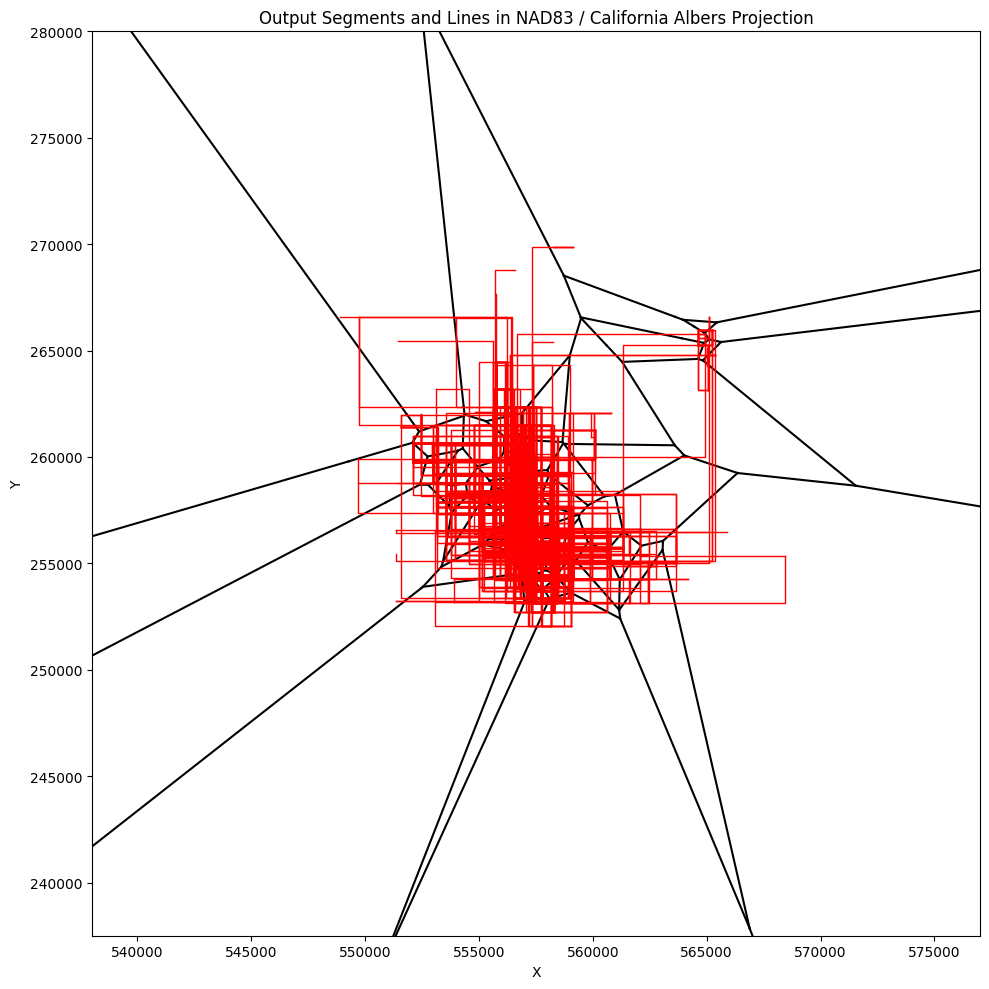

In [8]:
intersect = createIntersections(output_segments)
intersect.calculate_intersections()

intersections = intersect.get_intersections()
lines = intersect.get_lines()
line_segments = intersect.get_line_segments()

intersect.plot_map()

Plot the cell and the intersecting segments

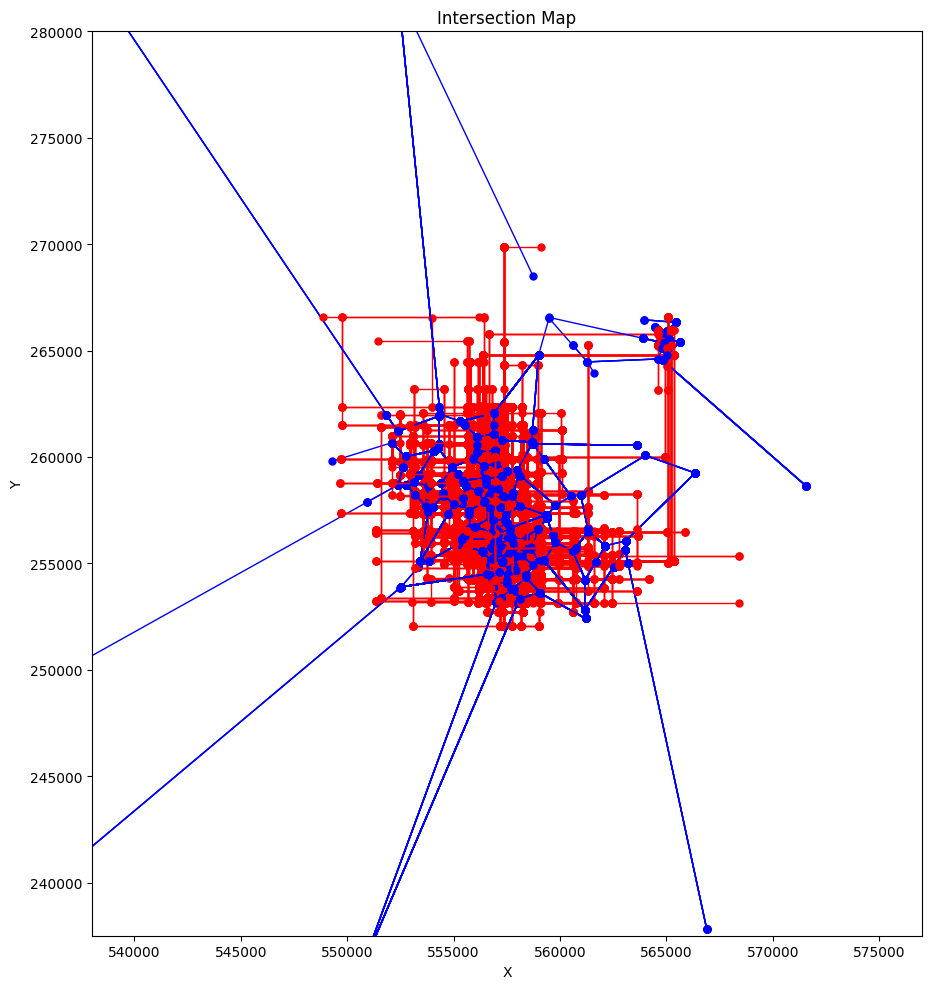

In [9]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the intersections
for intersection in intersections:
    p1, q1, p2, q2 = intersection
    ax.plot([p1[0], q1[0]], [p1[1], q1[1]], 'r-', linewidth=1)
    ax.plot([p2[0], q2[0]], [p2[1], q2[1]], 'b-', linewidth=1)
    ax.plot(p1[0], p1[1], 'ro', markersize=5)
    ax.plot(q1[0], q1[1], 'ro', markersize=5)
    ax.plot(p2[0], p2[1], 'bo', markersize=5)
    ax.plot(q2[0], q2[1], 'bo', markersize=5)

# Set the title and axis labels
ax.set_title('Intersection Map')
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.xlim(538000, 577000)
plt.ylim(237500, 280000)

# Set equal aspect ratio
ax.set_aspect('equal')

# Display the plot
plt.tight_layout()
plt.show()

Calculate averages

In [10]:
# Calculate the total number of intersections
total_intersections = len(intersections)

#count the voronois
vor_count = 0
for point in points: #The points dataset was chosen, because each point is a station and each station is in a voronoi.
    vor_count += 1

#calculate the average intersections per voronoi
avg_vor_intersections = total_intersections / vor_count

#print
print(f"Number of Intersections: {total_intersections}")
print(f"Number of Voronois: {vor_count}")
print(f"Average number of Voronoi intersections: {avg_vor_intersections}")

# Count the number of lines
lines_count = len(lines)

# Calculate the average number of intersections per line
avg_line_intersections = total_intersections / lines_count

#print
print(f"Number of Lines: {lines_count}")
print(f"Average number of Line intersections: {avg_line_intersections}")

seg_count = 0
for segment in line_segments:
    seg_count += 1

#calculate the average intersections per voronoi
avg_seg_intersections = total_intersections / seg_count

#print
print(f"Number of Segments: {seg_count}")
print(f"Average number of Segment intersections: {avg_seg_intersections}")

distances = [row['distance'] for row in results]
distance = 0
for dist in distances:
    distance += dist

avg_line_length = distance / lines_count

print(f"Average length of a Line: {avg_line_length}")

Number of Intersections: 21427
Number of Voronois: 84
Average number of Voronoi intersections: 255.08333333333334
Number of Lines: 5341
Average number of Line intersections: 4.011795543905635
Number of Segments: 10682
Average number of Segment intersections: 2.0058977719528177
Average length of a Line: 2297.5241796692244


In [11]:
# dictionary to count intersections for each voronoi segment
vor_segment_intersections = {}

# Iterate over each voronoi
for vor_coords in output_segments:
    vor_coords.append(vor_coords[0])  # Close the polygon
    for i in range(len(vor_coords) - 1):
        segment = (tuple(vor_coords[i]), tuple(vor_coords[i + 1]))
        reverse_segment = (tuple(vor_coords[i + 1]), tuple(vor_coords[i]))
        
        if segment not in vor_segment_intersections and reverse_segment not in vor_segment_intersections:
            vor_segment_intersections[segment] = 0

        # Count intersections for this segment
        for inter in intersections:
            if segment == (inter[0], inter[1]) or segment == (inter[1], inter[0]) or \
               segment == (inter[2], inter[3]) or segment == (inter[3], inter[2]) or \
               reverse_segment == (inter[0], inter[1]) or reverse_segment == (inter[1], inter[0]) or \
               reverse_segment == (inter[2], inter[3]) or reverse_segment == (inter[3], inter[2]):
                if segment in vor_segment_intersections:
                    vor_segment_intersections[segment] += 1
                else:
                    vor_segment_intersections[reverse_segment] += 1

# Get the maximum number of intersections
max_intersections = max(vor_segment_intersections.values(), default=0)

# Print the result
print(f"Max intersections for a Voronoi segment: {max_intersections}")


Max intersections for a Voronoi segment: 1136


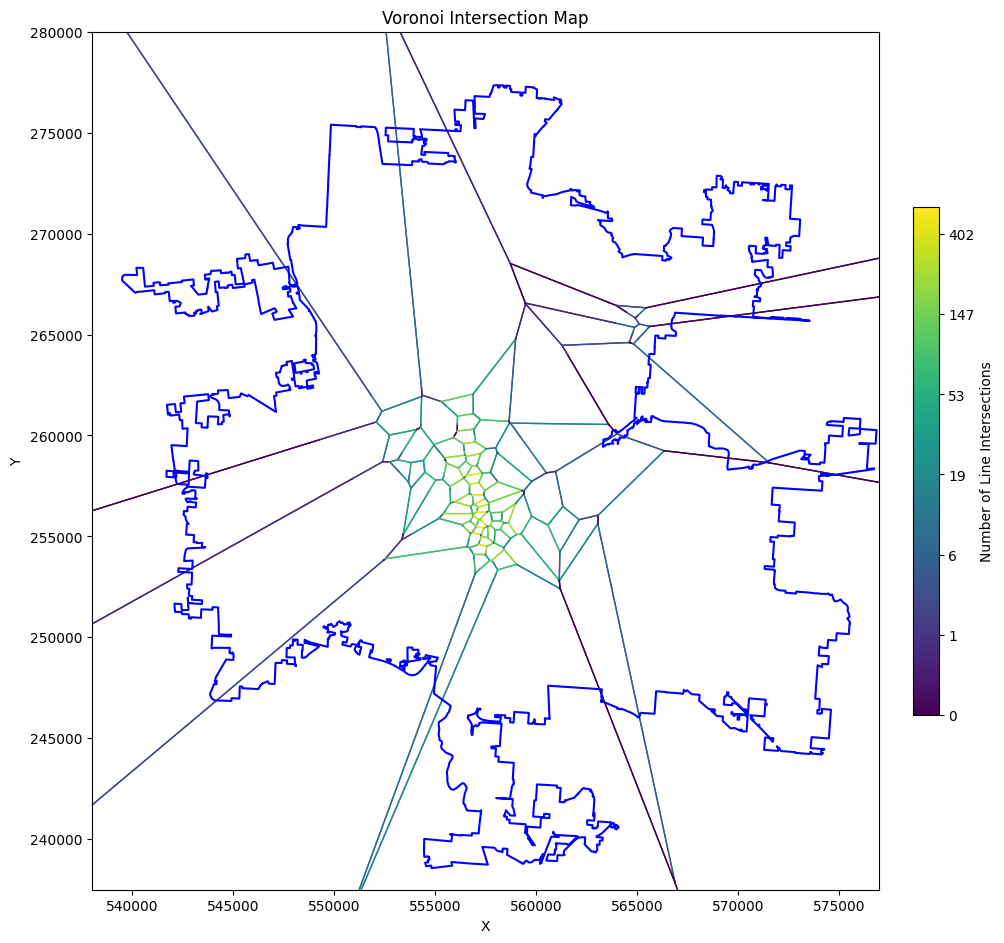

In [12]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Gather plot data
plot_data = []
intersection_counts = []
for vor_coords in output_segments:
    vor_coords.append(vor_coords[0])  
    xs, ys = zip(*vor_coords)
    
    for i in range(len(vor_coords) - 1):
        p1 = vor_coords[i]
        p2 = vor_coords[i + 1]
        
        # Find if the segment is in the intersections list
        intersection_count = sum(1 for inter in intersections if 
                                 (tuple(p1), tuple(p2)) in [(inter[0], inter[1]), (inter[1], inter[0]), (inter[2], inter[3]), (inter[3], inter[2])] or 
                                 (tuple(p2), tuple(p1)) in [(inter[0], inter[1]), (inter[1], inter[0]), (inter[2], inter[3]), (inter[3], inter[2])])
        
        
        plot_data.append(((xs[i], xs[i + 1]), (ys[i], ys[i + 1]), intersection_count))
        intersection_counts.append(intersection_count)

# Apply logarithmic scaling to intersection counts
log_intersection_counts = np.log1p(intersection_counts) 

# Get the maximum log-transformed intersection count for normalization
max_log_intersections = np.max(log_intersection_counts)

# Plot the voronoi with colored segments using logarithmic color scale
for ((x1, x2), (y1, y2), intersection_count), log_count in zip(plot_data, log_intersection_counts):
    color_value = log_count / max_log_intersections if max_log_intersections > 0 else 0
    ax.plot([x1, x2], [y1, y2], color=cmap(color_value), linewidth=1)

# Set the title and axis labels
ax.set_title('Voronoi Intersection Map')
ax.set_xlabel('X')
ax.set_ylabel('Y')

xs, ys = zip(*columbus_bd)
plt.plot(xs, ys, 'b-')

# Set equal aspect ratio
ax.set_aspect('equal')

# Create a colorbar with logarithmic scale to make the data more visible (due to a high number of low values)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_log_intersections))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)

# Show total counts instead of logarithmic scale
def log_tick_formatter(x, pos):
    return f"{int(np.exp(x) - 1):d}"

cbar.set_label('Number of Line Intersections')
cbar.formatter = FuncFormatter(log_tick_formatter)
cbar.update_ticks()

plt.xlim(538000, 577000)
plt.ylim(237500, 280000)

# Display the plot
plt.tight_layout()
plt.show()
